In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb

    path_andrey = '/Home/siv30/wad005/master/GRB/MATLAB/andrey_mezentsev/'

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    path_andrey = '/Users/andreas/phys/master/GRB/MATLAB/andrey_mezentsev/'
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
import numpy as np
from numpy.polynomial.polynomial import polyval,polyfit
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def calculate_T90(GRB_id=None, binsize=None, tlagg_asim=None, T0=None, bak_interval=None, poly_degree=0, mean_index=None, info_text=None, export=False):
    """
    Calculate the T90 duration of a given Gamma-Ray Burst (GRB).

    Parameters:
    GRB_id (str): The identification of the GRB.
    binsize (float): The size of the bins for the histogram.
    tlagg_asim (float): The time lag.
    T0 (str): The initial time in ISO format.
    bak_interval (list of tuples): The intervals for the background estimation.
    poly_degree (int, optional): The degree of the polynomial for the background fit. Defaults to 1.
    mean_index (int, optional): The index at which the mean of the cumulative counts is estimated. Defaults to -40.

    Returns:
    float: The T90 duration of the GRB.
    """
    
    # Check if all necessary parameters are provided
    if not all([GRB_id, binsize, tlagg_asim, T0, bak_interval]):
        raise ValueError("All parameters must be provided.")
   
    # Load data
    asimData = pd.read_csv(f'{path_andrey}{GRB_id}.csv')
    asimData['tus'] /= 1e6
    asimData['tus'] += tlagg_asim
    tus_asim = asimData['tus'].to_numpy()

    # Calculate T0
    T0 = datetime.fromisoformat(T0) + timedelta(seconds=tlagg_asim)
    print(f'T0 {T0}, applied time lagg: {np.round(tlagg_asim,5)} s')

     # Create histogram
    grb_hist = np.histogram(tus_asim, np.arange(tus_asim[0], tus_asim[-1] + binsize, binsize))
    grb_counts, grb_edges = grb_hist[0], grb_hist[1]

    # Initialize background level array
    background_level = np.zeros_like(grb_counts)

    # Calculate background level for each interval
    for interval in bak_interval:
        ti_bkg, tf_bkg = interval
        background_range = (grb_edges[:-1] >= ti_bkg) & (grb_edges[:-1] < tf_bkg)

        # Use polynomial of n-th degree to fit the background level
        polyCoefs = polyfit(grb_edges[:-1][background_range], grb_counts[background_range], poly_degree)

        # Calculate the background level for this interval
        background_level[background_range] = polyval(grb_edges[:-1][background_range], polyCoefs)
    
    # Subtract background
    background_subtracted = grb_counts - background_level

    # Calculate cumulative sum
    cumulative_counts = np.cumsum(background_subtracted)

    # Calculate T90
    total_counts = np.mean(cumulative_counts[mean_index:])

    t1 = grb_edges[np.searchsorted(cumulative_counts, 0.05 * total_counts)]
    t2 = grb_edges[np.searchsorted(cumulative_counts, 0.95 * total_counts)]
    T90 = t2 - t1

    # Plotting
    plt.step(grb_edges[:-1], grb_counts, color='black')
    plt.title(f'Light Curve for {GRB_id}')
    plt.xlabel('Time from T0 (s)')
    plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
    print(background_range)
    plt.plot(grb_edges[:-1][background_range], background_level, color='blue', linestyle='--', label='Background Level') # line representing the background level
    for interval in bak_interval:
        plt.axvline(x=interval[0], ymin=0, ymax=0.68, color='g',linestyle='--',label='Start of bkg')
        plt.axvline(x=interval[1], ymin=0, ymax=0.68, color='r',linestyle='--',label='End of bkg')
    plt.legend()
    plt.show()

    # Ploting LC with background subtraced
    print(f'Mean background level: {np.round(np.mean(background_level))} / {binsize} [counts/s]')
    plt.step(grb_edges[:-1], background_subtracted, color='black',where='post')
    plt.title(f'Background Subtracted Light Curve for {GRB_id}')
    plt.xlabel('T-T0 (s)')
    plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
    for interval in bak_interval:
        plt.axvline(x=interval[0], ymin=0, ymax=0.68, color='g',linestyle='--',label='Start of bkg')
        plt.axvline(x=interval[1], ymin=0, ymax=0.68, color='r',linestyle='--',label='End of bkg')
    plt.plot(grb_edges[:-1], background_level, color='blue', linestyle='--', label='Background Level')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.legend()
    plt.show()

    # Plot cumulative counts
    print(f"T90 for {GRB_id} = {np.round(T90,5)} s")
    print(f'Mean total counts: {np.round(total_counts)} estimated from T0 {np.round(grb_edges[mean_index],3)} --> {np.round(grb_edges[-1],3)}')
    plt.plot(grb_edges[:-1], cumulative_counts,color='black')
    plt.title(f'Cumulative Counts for {GRB_id}')
    plt.xlabel('T-T0 (s)')
    plt.ylabel(f'Cumulative Counts per {format(binsize*1000, ".0f")} ms')

    # Add horizontal lines at 5% and 95% of total counts
    plt.axhline(y=0, color='black',linestyle='--',label='0')
    plt.axhline(y=0.05 * total_counts, color='g', linestyle='--',label='0.05%')
    plt.axhline(y=0.95 * total_counts, color='r', linestyle='--',label='0.95%')
    plt.axhline(y=total_counts, color='b', linestyle='--',label='~100%') # Add horizontal line at the average of the last elements
    plt.axvline(x=grb_edges[mean_index],color='orange',linestyle='--',label='Start of mean total')
    plt.legend()
    plt.show()

    # Plot background subtracted light curve
    plt.step(grb_edges[:-1], background_subtracted,color='black',where='post')
    plt.title(f'Background Subtracted Light Curve for {GRB_id}')
    plt.xlabel('Time from T0 (s)')
    plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')

    # Add vertical lines at t1 and t2 to indicate the T90 interval
    plt.axvline(x=t1, color='g', linestyle='--', label='Start of T90')
    plt.axvline(x=t2, color='r', linestyle='--', label='End of T90')

    plt.legend()
    plt.show()

    
    if export==True and info_text!=None:
        # Create a new PDF file
        pdf_pages = PdfPages(f'{GRB_id}_T90report.pdf')
        
        # Create a blank figure for the text
        fig0 = plt.figure(figsize=(11, 8))
        plt.axis('off')
        plt.text(0, 0, info_text, fontsize=16)
        pdf_pages.savefig(fig0)

        # Save figures to the PDF
        fig1 = plt.figure()
        plt.step(grb_edges[:-1], grb_counts,color='black',where='post')
        plt.title(f'Light Curve for {GRB_id}')
        plt.xlabel('Time from T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        plt.axvline(x=ti_bkg, ymax=0.68, color='g',linestyle='--',label='Start of bkg')
        plt.axvline(x=tf_bkg, ymax=0.68, color='r',linestyle='--',label='End of bkg')
        plt.text(0.05, 0.95, f'T0: {T0}, applied time lagg: {np.round(tlagg_asim,5)} s', transform=plt.gca().transAxes)
        pdf_pages.savefig(fig1)

        fig2 = plt.figure()
        plt.step(grb_edges[:-1], background_subtracted,color='black',where='post')
        plt.title(f'Background Subtracted Light Curve for {GRB_id}')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        plt.text(0.05, 0.95, f'Mean background level: {np.round(np.mean(background_level),0)} / {format(binsize*1000, ".0f")} [counts/ms]', transform=plt.gca().transAxes)
        plt.axvline(x=t1, color='g', linestyle='--', label='Start of T90')
        plt.axvline(x=t2, color='r', linestyle='--', label='End of T90')
        plt.legend()
        pdf_pages.savefig(fig2)

        fig3 = plt.figure()
        plt.plot(grb_edges[:-1], cumulative_counts,color='black')
        plt.title(f'Cumulative Counts for {GRB_id}')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Cumulative Counts per {format(binsize*1000, ".0f")} ms')
        plt.text(0.05, 0.95, f'T90 for {GRB_id} = {np.round(T90,5)} s', transform=plt.gca().transAxes)
        plt.text(0.05, 0.90, f'Mean total counts: {np.round(total_counts)}', transform=plt.gca().transAxes)
        plt.axhline(y=0.05 * total_counts, color='g', linestyle='--',label='0.05%')
        plt.axhline(y=0.95 * total_counts, color='r', linestyle='--',label='0.95%')
        plt.axhline(y=total_counts, color='b', linestyle='--',label='~100%')
        plt.axvline(x=grb_edges[mean_index],color='orange',linestyle='--',label='Start of mean total')
        plt.axhline(y=0,linestyle='--',color='black')
        plt.legend()
        pdf_pages.savefig(fig3)

        # Close the PDF file
        pdf_pages.close()
        
        return T90
    else:
        return T90

# Estimating T90; General Procedure
    1) importing the ASIM data (Andrey data), applying cross correlation time lagg from previous calculations
    2) binning by 2 ms (or what is appropriate for the specific light curve)
    3) estimating background --> subtracting background from LC using a polynomial of n-th (0->constant) degree to fit the background 
    4) apply np.cumsum() on binned data
    5) Find total number of cumulative counts, calculate % and find T90

## General Notes        
    Unrealiable background --> is overestimated resulting in negative counts
    Tried with a quadratic fit, but error persists --> Using linear fit to estimate background due to short interval
    Clipping the background subtracted lightcurve to 0, results in T90 overestimated --> Cumulative curve is monotonically increasing!
        
    => We learned that we have to keep the negative counts in the background subtracted lightcurve for the cumulative curve to converge.
    
    => We approxiame the total number of cumulative counts after convergence by calculating the mean of the last N bins in the background subtracted light curve. This N parameter affect the T90 estimation
    
    => Important to choose an appropriate binsize that minimizes noise in the light curve. If the cumulative sum doesn't converge, the T90 estimation fails. Therefore it's important to move the N parameter (mean_index), when binsize is changed

In [12]:
info_GRB190606A = "GRB190606A: Short, bright, good starting point!\n\nT90 ends at significant count rate drop.\n\nBackground: Polynomial approximation (0-th degree), ti=-1.0 s, tf=-0.2 s.\n\nT90 estimations (binsize, mean_index, T90):\n- 1ms, -520: 0.165 s\n- 2ms, -260: 0.164 s\n- 4ms, -130: 0.164 s\n- 8ms, -65: 0.168 s\n- 16ms, -32: 0.160 s\n"

In [ ]:
T90 = calculate_T90('GRB190606A', 0.008, -0.5366225269343781, '2019-06-06T01:55:07.318605', -1, -0.2, mean_index=-65,poly_degree=0,
                    export=False,  info_text=info_GRB190606A)

### GRB 201227A
    -Difficult to calculate the background on the interval
    -T90 reported by Fermi: 0.1 s (50-300 keV) =>Suggesting to also calculate the backgorund after the burst

info_GRB201227A = "GRB 201227A: Short, bright, another good bright burst!\n\nT90 ends at significant count rate drop.\n\nBackground: Polynomial approximation (0-th degree), ti=- s, tf=- s.\n\nT90 estimations (binsize, mean_index, T90):\n- 1ms, -:  s\n- 2ms, -: 0. s\n- 4ms, -: 0. s\n- 8ms, -: 0. s\n- 16ms, -: 0. s\n"

T0 2020-12-27 15:14:06.322667, applied time lagg: -0.531 s
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False False False False]


ValueError: x and y must have same first dimension, but have shapes (31,) and (126,)

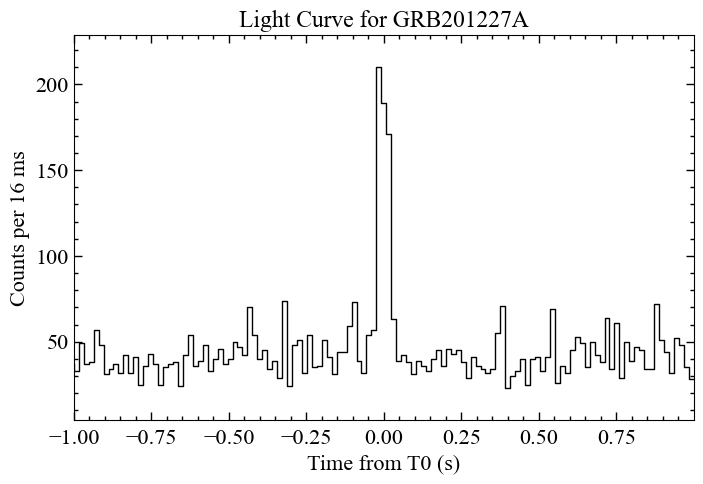

In [72]:
T90 = calculate_T90(GRB_id='GRB201227A', binsize=0.016,tlagg_asim=-0.531, T0='2020-12-27T15:14:06.853667', bak_interval=[[-0.95, -0.45],[0.25,0.75]], mean_index=-30,poly_degree=0,
                    export=False, info_text=None)